# CatBoost Modeling

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |█████████████████▏              | 310.7 MB 184.7 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 57 kB 95.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 74.1 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 128.1 MB/s eta 0:00:01
     |████████████████████████████████| 438 kB 154.5 MB/s eta 0:00:01
     |████████████████████████████████| 14.1 MB 110.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 106.0 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 109.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 90.6 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 75.0 MB/s  eta 0:00:01
     |████████████████████████████████| 5.9 MB 113.6 MB/s eta 0:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

2022-10-20 18:46:38.053750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 18:46:38.191585: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 18:46:38.854239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64


['/device:CPU:0', '/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5', '/device:GPU:6', '/device:GPU:7']


2022-10-20 18:46:39.804880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 18:46:44.292924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 38407 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-10-20 18:46:44.294844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 38407 MB memory:  -> device: 1, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2022-10-20 18:46:44.296514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:2 with 38407 MB memory:  -> device: 2, name: A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capab

In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 76.7 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 109.6 MB/s eta 0:00:01
     |████████████████████████████████| 15.2 MB 140.6 MB/s eta 0:00:01


In [4]:
import pandas as pd
import numpy as np
# import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import joblib
import time

from catboost import CatBoostClassifier

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, plot_importance
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import cross_val_score 
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings('ignore')

In [5]:
%cd ..

/workspace/asurion_f22


In [6]:
test = pd.read_csv('fe_data/sale_data/test_sale_encoded.csv', index_col='id')

In [7]:
test.columns

Index(['quality_sale', 'accepted_flg', 'clndr_dt_cst', 'start_dt', 'lines',
       'previous_tech_support_call', 'account_tenure', 'past_yr_claim_count',
       'num_decline', 'exp', 'product_type', 'pmake', 'claritas_hh_count',
       'technodoption_class', 'hh_income', 'age_class', 'hh_education',
       'hh_composition', 'hh_tenure', 'urbanicity', 'median_income',
       'total_population', 'perc_female', 'perc_under18', 'perc_over65',
       'perc_white', 'perc_black', 'population_density', 'zipcode', 'county',
       'state', 'state_code', 'latitude', 'longitude', 'month',
       'hh_income_code', 'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers'],
      dtype='object')

In [8]:
dcols = ['accepted_flg', 'clndr_dt_cst', 'start_dt', 'zipcode', 'county', 'state', 
         'state_code', 'latitude', 'longitude', 'month','hh_income_code']

In [9]:
test.drop(columns = dcols, inplace = True)
test = test[(test['zipcode_accepted_prop'].isnull()==False)& (test['zipcode_rejected_offers'].isnull()==False)& 
            (test['zipcode_accepted_offers'].isnull()==False)&(test['zipcode_total_offers'].isnull()==False)]

In [10]:
test["quality_sale"].dtype

dtype('int64')

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184044 entries, c27e6b798c0ae161fad4a807f097dd233a52c7b8d72c777799c0bec9 to 47810e5077e068e636991f9f726806837a0d3b7f1f44f1aa4ba151e7
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   quality_sale                184044 non-null  int64  
 1   lines                       184044 non-null  float64
 2   previous_tech_support_call  184044 non-null  float64
 3   account_tenure              184044 non-null  float64
 4   past_yr_claim_count         184044 non-null  float64
 5   num_decline                 184044 non-null  float64
 6   exp                         184044 non-null  float64
 7   product_type                184044 non-null  object 
 8   pmake                       184044 non-null  object 
 9   claritas_hh_count           184044 non-null  float64
 10  technodoption_class         184044 non-null  object 
 11  hh_income                   18

In [12]:
test.to_csv('fe_data/sale_data/testing.csv')

In [13]:
test = pd.read_csv("fe_data/sale_data/testing.csv", index_col = "id")

In [14]:
train = pd.read_csv('fe_data/sale_data/train_sale_encoded.csv', index_col='id')

In [15]:
train.drop(columns = dcols, inplace = True)
train = train[(train['zipcode_accepted_prop'].isnull()==False)& (train['zipcode_rejected_offers'].isnull()==False)& 
            (train['zipcode_accepted_offers'].isnull()==False)&(train['zipcode_total_offers'].isnull()==False)]

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 863505 entries, c90ce3eaafffd07a32cb9cf4d153aef6f524b29aeef447ba3200efdb to 66b4c3759f378f38589395fd0353856239da965077903f31b30e87fc
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   quality_sale                863505 non-null  int64  
 1   lines                       863505 non-null  int64  
 2   previous_tech_support_call  863505 non-null  int64  
 3   account_tenure              863505 non-null  int64  
 4   past_yr_claim_count         863505 non-null  int64  
 5   num_decline                 863505 non-null  int64  
 6   exp                         863505 non-null  int64  
 7   product_type                863505 non-null  object 
 8   pmake                       863505 non-null  object 
 9   claritas_hh_count           863505 non-null  int64  
 10  technodoption_class         863505 non-null  object 
 11  hh_income                   86

In [17]:
train.to_csv('fe_data/sale_data/training.csv')

In [18]:
train.shape

(863505, 31)

In [19]:
#num_list = ['lines', 'previous_tech_support_call', 'account_tenure', 'past_yr_claim_count', 'num_decline', 
#            'claritas_hh_count', 'median_income', 'total_population', 'perc_female', 'perc_under18',
#            'perc_over65', 'perc_white', 'perc_black', 'population_density',
#            'zipcode_accepted_prop', 'zipcode_rejected_offers', 'zipcode_accepted_offers', 'zipcode_total_offers']
#cat_list = ['exp', 'product_type', 'pmake', 'technodoption_class', 'hh_income', 'age_class', 'hh_education', 
#            'hh_composition', 'hh_tenure', 'urbanicity', 'day_of_week', 'time_of_day']
#len(num_list+cat_list)

In [20]:
train = pd.read_csv('fe_data/sale_data/training.csv', index_col='id')
#test = pd.read_csv('fe_data/sale_data/testing.csv', index_col='id')

In [21]:
train.columns

Index(['quality_sale', 'lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers'],
      dtype='object')

In [22]:
#test.columns

In [23]:
total_data = train.copy()

In [24]:
total_data.columns

Index(['quality_sale', 'lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers'],
      dtype='object')

In [25]:
def transform_xy(dat):
    X_ori = dat[[
#         'emplid','cvp_call_id',
                 'lines', 'previous_tech_support_call','account_tenure', 'past_yr_claim_count', 
                'num_decline', 'exp', 
#                  'churn',
                 'product_type', 'pmake', 
                 'claritas_hh_count',
                 'technodoption_class', 'hh_income', 'age_class', 'hh_education',
                 'hh_composition', 'hh_tenure', 'urbanicity','median_income', 'total_population', 
                 'perc_female', 'perc_under18',
                'perc_over65', 'perc_white', 'perc_black', 'population_density', 'day_of_week', 'time_of_day',
       'zipcode_accepted_prop', 'zipcode_rejected_offers',
       'zipcode_accepted_offers', 'zipcode_total_offers']]
    y = dat[['quality_sale']]
   
    X_ori.loc[X_ori.lines.isnull(), 'lines'] = 0
    X_ori.exp = X_ori.exp.apply(int)
    X_ori.num_decline = X_ori.num_decline.apply(float)
    X_ori.loc[X_ori.account_tenure.isnull(), 'account_tenure'] = 0
    X_ori.loc[X_ori.claritas_hh_count.isnull(), 'claritas_hh_count'] = 0
    X_ori.loc[X_ori.exp.isnull(), 'exp'] = 'Unknown'
    X_ori.loc[X_ori.product_type.isnull(), 'product_type'] = 'Unknown'
    X_ori.loc[X_ori.pmake.isnull(), 'pmake'] = 'Unknown'
    X_ori.loc[X_ori.technodoption_class.isnull(), 'technodoption_class'] = 'Unknown'
    X_ori.loc[X_ori.hh_income.isnull(), 'hh_income'] = 'Unknown'
    X_ori.loc[X_ori.age_class.isnull(), 'age_class'] = 'Unknown'
    X_ori.loc[X_ori.hh_education.isnull(), 'hh_education'] = 'Unknown'
    X_ori.loc[X_ori.hh_composition.isnull(), 'hh_composition'] = 'Unknown'
    X_ori.loc[X_ori.hh_tenure.isnull(), 'hh_tenure'] = 'Unknown'
    X_ori.loc[X_ori.urbanicity.isnull(), 'urbanicity'] = 'Unknown'
    X_ori.loc[X_ori.day_of_week.isnull(), 'day_of_week'] = 'Unknown'
    X_ori.loc[X_ori.time_of_day.isnull(), 'time_of_day'] = 'Unknown'
    X_ori.loc[X_ori.zipcode_accepted_prop.isnull(), 'zipcode_accepted_prop'] = 0
    X_ori.loc[X_ori.zipcode_rejected_offers.isnull(), 'zipcode_rejected_offers'] = 0
    X_ori.loc[X_ori.zipcode_accepted_offers.isnull(), 'zipcode_accepted_offers'] = 0
    X_ori.loc[X_ori.zipcode_total_offers.isnull(), 'zipcode_total_offers'] = 0
    return X_ori,y

In [26]:
X,y = transform_xy(total_data)

In [27]:
X['lines'] = X['lines'].astype(np.int) 
X['previous_tech_support_call'] = X['previous_tech_support_call'].astype('category')
X['num_decline'] = X['num_decline'].astype(np.int) 
X['past_yr_claim_count'] = X['past_yr_claim_count'].astype(np.int) 
X['exp'] = X['exp'].astype('category') 
X['account_tenure'] = X['account_tenure'].astype(np.int) 
X['pmake'] = X['pmake'].astype('category')
X['technodoption_class'] = X['technodoption_class'].astype('category')
X['claritas_hh_count'] = X['claritas_hh_count'].astype('category')
X['hh_income'] = X['hh_income'].astype('category')
X['age_class'] = X['age_class'].astype('category')
X['hh_education'] = X['hh_education'].astype('category')
X['hh_composition'] = X['hh_composition'].astype('category')
X['hh_tenure'] = X['hh_tenure'].astype('category')
X['urbanicity'] = X['urbanicity'].astype('category')
X['product_type'] = X['product_type'].astype('category')
X['day_of_week'] = X['day_of_week'].astype('category')
X['time_of_day'] = X['time_of_day'].astype('category')
X['zipcode_accepted_prop'] = (X['zipcode_accepted_prop']*100).astype(np.int)
X['zipcode_rejected_offers'] = X['zipcode_rejected_offers'].astype(np.int)
X['zipcode_accepted_offers'] = X['zipcode_accepted_offers'].astype(np.int)
X['zipcode_total_offers'] = X['zipcode_total_offers'].astype(np.int)

X['median_income'] = X['median_income'].astype(np.int)
X['total_population'] = X['total_population'].astype(np.int)
X['perc_female'] = X['perc_female'].astype(np.int)
X['perc_under18'] = X['perc_under18'].astype(np.int)
X['perc_over65'] = X['perc_over65'].astype(np.int)
X['perc_white'] = X['perc_white'].astype(np.int)
X['perc_black'] = X['perc_black'].astype(np.int)
X['population_density'] = X['population_density'].astype(np.int)

# ['median_income', 'total_population', 'perc_female', 'perc_under18',
#        'perc_over65', 'perc_white', 'perc_black', 'population_density',
#        'latitude', 'longitude', 'month', 'day_of_week',
#        'time_of_day', 'zipcode_accepted_prop', 'zipcode_rejected_offers',
#        'zipcode_accepted_offers', 'zipcode_total_offers']


#Xf_train, Xf_test, y_train, y_test = train_test_split(X,y, test_size = 0.3,stratify=y)

In [28]:
Xf_train, Xf_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [29]:
X

,lines,previous_tech_support_call,account_tenure,past_yr_claim_count,num_decline,exp,product_type,pmake,claritas_hh_count,technodoption_class,hh_income,age_class,hh_education,hh_composition,hh_tenure,urbanicity,median_income,total_population,perc_female,perc_under18,perc_over65,perc_white,perc_black,population_density,day_of_week,time_of_day,zipcode_accepted_prop,zipcode_rejected_offers,zipcode_accepted_offers,zipcode_total_offers
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c90ce3eaafffd07a32cb9cf4d153aef6f524b29aeef447ba3200efdb,2,15,1286,2,3,1,SD,android,2576615,Mid-Tech,1 Wealthy,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,7 Metro Mix,134658,13596,47,13,37,91,0,0,Monday,20,5,55,3,58
91aa94d54079b20e2a18b09c070d0304b3df9c7272e9fc75470cb2ff,1,10,216,5,13,1,SD,android,2507965,High-Tech,3 Upper Midscale,2 Middle Age,2 College Graduate,1 w/ Kids,1 Homeowners,8 Mix,56714,30122,52,24,16,57,34,616,Thursday,21,9,110,12,122
eb269842f94437bfd7e3a5a1f30d7b9a84a842afd8a153e8788c0d45,5,30,6559,0,11,1,MD,android,2576615,Mid-Tech,1 Wealthy,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,7 Metro Mix,130557,33039,49,28,9,64,6,2232,Wednesday,13,6,103,7,110
fc05f45119a8a4b830a3463bfc8a7113b2807c88e7d2da0320e559df,5,1,3944,0,0,1,MD,android,2576615,Mid-Tech,1 Wealthy,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,7 Metro Mix,116157,51830,50,19,21,20,0,1507,Tuesday,12,10,78,9,87
68943556bf63277816d843ffb129e23ffe60bc5b982603ec9519659a,2,4,689,1,8,1,SD,android,1715961,High-Tech,4 Midscale,1 Younger,3 Some College,1 w/ Kids,5 Renters,7 Metro Mix,49842,34512,48,27,9,74,11,1894,Tuesday,12,18,57,13,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94af2fb8539fbb688fb3501edf8bd0a31cc431d2b1c5e3c4ed6506e2,3,2,595,0,1,0,SD,other,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,34145,9512,49,18,12,66,16,4522,Wednesday,9,3,28,1,29
51c8fb1e7ae3bcc139e84f5aa59b45e2af6db8794ec2652f85bb5b2c,0,2,2569,1,0,0,SD,other,2444705,Mid-Tech,2 Upscale,3 Older,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,8 Mix,57442,26854,47,21,15,92,0,46,Saturday,12,7,89,7,96
9d641dfeaa833f98c13709b9b5389db3f9051fa354f588237a9d9e34,5,4,2268,0,2,0,MD,other,2804875,No-Tech,4 Midscale,4 Mature,3 Some College,5 w/o Kids,2 Mostly Owners,8 Mix,51530,26281,53,16,28,93,0,414,Sunday,19,10,169,19,188


In [30]:
X_train_census = Xf_train
X_test_census = Xf_test

In [31]:
X_train_census

,lines,previous_tech_support_call,account_tenure,past_yr_claim_count,num_decline,exp,product_type,pmake,claritas_hh_count,technodoption_class,hh_income,age_class,hh_education,hh_composition,hh_tenure,urbanicity,median_income,total_population,perc_female,perc_under18,perc_over65,perc_white,perc_black,population_density,day_of_week,time_of_day,zipcode_accepted_prop,zipcode_rejected_offers,zipcode_accepted_offers,zipcode_total_offers
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
78e5feb38f9fb9d2920d32a06fde9d99ebd92e4c38f1eb78709f219c,6,6,3954,1,4,1,MD,ios,2576615,Mid-Tech,1 Wealthy,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,7 Metro Mix,88101,21437,51,20,15,64,6,5574,Saturday,20,6,45,3,48
9895beb53d77ad1c82615a3a5b93b45887a07dde2dd5d309bd510722,2,9,2756,1,1,0,SD,android,2382862,Mid-Tech,2 Upscale,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,5 Rural,55832,24763,54,24,17,59,35,455,Thursday,14,16,103,20,123
e5a2eac79449a1000f39d2642f9371039d0caf33986fe9cb9c2eec1e,1,12,2649,8,4,0,SD,android,2291228,High-Tech,1 Wealthy,2 Middle Age,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,7 Metro Mix,139697,64798,52,17,12,63,12,44941,Sunday,13,3,135,5,140
3e2d16d0bc9b75601eb2aeefdebb5f9d86dfc11ceeb21309fcfe3b1e,2,3,3727,0,3,1,SD,android,2444705,Mid-Tech,2 Upscale,3 Older,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,8 Mix,63135,37349,52,19,18,78,9,1901,Saturday,14,5,113,7,120
4bfe62219cf39b48010bfb156f0910162c8e6b387abddfe0ad21cec4,7,1,1310,1,3,1,MD,ios,2014583,High-Tech,2 Upscale,2 Middle Age,1 Graduate Plus,1 w/ Kids,2 Mostly Owners,5 Rural,71880,13457,49,27,16,81,12,131,Saturday,9,2,42,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3fd2a5809a85c173a0c3059110e2f6e9e23537a1bf0b49835a1af8fe,2,4,1887,1,3,0,SD,android,1820797,Mid-Tech,3 Upper Midscale,3 Older,2 College Graduate,1 w/ Kids,2 Mostly Owners,8 Mix,72675,11141,50,10,48,88,1,0,Thursday,11,8,102,9,111
1f7eb70ced6c3f55da7cd9157112f84eda72d5fc60b14d1fc11e1d69,5,3,665,2,6,1,MD,ios,2014583,High-Tech,2 Upscale,2 Middle Age,1 Graduate Plus,1 w/ Kids,2 Mostly Owners,5 Rural,79410,1526,43,5,17,97,0,93,Friday,13,0,7,0,7
dc4b9e68d97ccaf3f306f52c8ee231b21ea6959db433053639dd8b02,0,7,681,1,7,1,MD,ios,2884959,High-Tech,3 Upper Midscale,2 Middle Age,3 Some College,5 w/o Kids,2 Mostly Owners,5 Rural,84716,1554,60,23,20,99,0,70,Monday,15,6,14,1,15


In [32]:
#X_train_census = X_train_census.iloc[: , 1:]
#X_train_census.drop(columns=X_train_census.columns[0], axis=1, inplace=True)
#X_train_census=Xf_train.drop(columns=['id'])
#X_test_census = Xf_test.drop(columns=['id'])

In [33]:
X_train_census.reset_index(drop = True, inplace = True)
X_test_census.reset_index(drop = True, inplace = True)
X_train_census.head()

,lines,previous_tech_support_call,account_tenure,past_yr_claim_count,num_decline,exp,product_type,pmake,claritas_hh_count,technodoption_class,hh_income,age_class,hh_education,hh_composition,hh_tenure,urbanicity,median_income,total_population,perc_female,perc_under18,perc_over65,perc_white,perc_black,population_density,day_of_week,time_of_day,zipcode_accepted_prop,zipcode_rejected_offers,zipcode_accepted_offers,zipcode_total_offers
0,6,6,3954,1,4,1,MD,ios,2576615,Mid-Tech,1 Wealthy,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,7 Metro Mix,88101,21437,51,20,15,64,6,5574,Saturday,20,6,45,3,48
1,2,9,2756,1,1,0,SD,android,2382862,Mid-Tech,2 Upscale,3 Older,1 Graduate Plus,5 w/o Kids,1 Homeowners,5 Rural,55832,24763,54,24,17,59,35,455,Thursday,14,16,103,20,123
2,1,12,2649,8,4,0,SD,android,2291228,High-Tech,1 Wealthy,2 Middle Age,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,7 Metro Mix,139697,64798,52,17,12,63,12,44941,Sunday,13,3,135,5,140
3,2,3,3727,0,3,1,SD,android,2444705,Mid-Tech,2 Upscale,3 Older,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,8 Mix,63135,37349,52,19,18,78,9,1901,Saturday,14,5,113,7,120
4,7,1,1310,1,3,1,MD,ios,2014583,High-Tech,2 Upscale,2 Middle Age,1 Graduate Plus,1 w/ Kids,2 Mostly Owners,5 Rural,71880,13457,49,27,16,81,12,131,Saturday,9,2,42,1,43


In [34]:
y_test.value_counts()/len(y_test)

quality_sale
0              0.91
1              0.09
dtype: float64

In [35]:
X_train_census.columns[15]

'urbanicity'

In [36]:
!pip install ipywidgets
!pip install catboost
import ipywidgets
import catboost as cb
from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 134 kB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 35.7 MB/s eta 0:00:01
     |████████████████████████████████| 384 kB 151.5 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [37]:
train_census_dataset = cb.Pool(X_train_census,y_train, 
                        cat_features=np.where(X_train_census.dtypes != np.int)[0])                                                      
test_census_dataset = cb.Pool(X_test_census,y_test,           
                       cat_features=np.where(X_test_census.dtypes != np.int)[0])

In [38]:
cat_model_census = CatBoostClassifier(
    cat_features = np.where(X_train_census.dtypes != np.int)[0],
    scale_pos_weight=10.5,
    max_depth = 7,
    learning_rate = 0.05
)

In [39]:
cat_model_census.fit(train_census_dataset, 
       eval_set=test_census_dataset,
      plot=True, silent= True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [40]:
#onehot = OneHotEncoder(handle_unknown='ignore')
#minmax = MinMaxScaler()
#ct = ColumnTransformer([("minmax", minmax, num_list)])
#pipeline = Pipeline([("mdl", cat_model_census)])

tuning_grid = {'mdl__scale_pos_weight' : [10.5], 
               'mdl__max_depth' : [7,8,9,10],
               'mdl__learning_rate': [0.05, 0.1],
               'mdl__n_estimators': [10]
                }

grid_search = GridSearchCV(pipeline, param_grid = tuning_grid, cv = 5, return_train_score=True)
start=time.time()

In [41]:
#.fit(X_train_census, y_train)
#print('best score for grid search:', grid_search.best_score_)

#display(pipeline.best_params_)
#print('Timer:', time.time()-start, 'seconds')
#cat_classifier = pipeline.best_estimator_

In [42]:
cat_classifier = cat_model_census

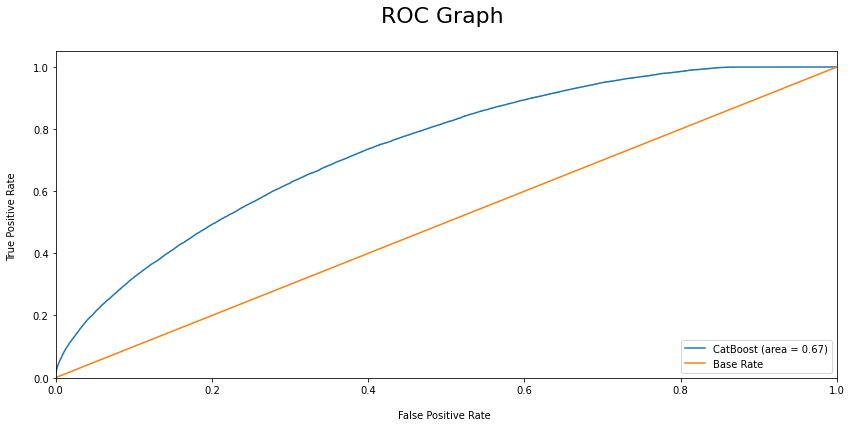

In [43]:
y_pred = cat_classifier.predict(X_test_census)
preds = cat_classifier.predict_proba(X_test_census)
from sklearn.metrics import auc, roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, preds[:,1])
plt.figure(figsize=(14, 6))

# Plot RF ROC
plt.plot(fpr, tpr, label='CatBoost (area = %0.2f)' % roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.ylabel('True Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()


In [44]:
threshold=0.5
predictions = (preds[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("catboost_testset",'\n',
      "recall:",recall_score(y_test, predictions),'\n',
      "precision:",precision_score(y_test, predictions),'\n',
      "f1score:",f1_score(y_test, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

catboost_testset 
 recall: 0.7431093346656674 
 precision: 0.15691239175348368 
 f1score: 0.25911166278318565 
 tn:139137, fp:95897, fn:6170, tp:17848 



In [45]:
threshold=0.55
predictions = (preds[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("catboost_testset",'\n',
      "recall:",recall_score(y_test, predictions),'\n',
      "precision:",precision_score(y_test, predictions),'\n',
      "f1score:",f1_score(y_test, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

catboost_testset 
 recall: 0.6353151802814556 
 precision: 0.17456213606671778 
 f1score: 0.27387351814127125 
 tn:162880, fp:72154, fn:8759, tp:15259 



In [46]:
joblib.dump(cat_classifier, 'catboost.pkl')

['catboost.pkl']

In [47]:
test = pd.read_csv('fe_data/sale_data/testing.csv', index_col='id')

In [48]:
for col in list(test.columns)[1:]:
    if test[col].dtype == 'float64':
        test[col] = test[col].astype("int64")

In [49]:
X_out,y_out = transform_xy(test)

In [50]:
y_out.value_counts()

quality_sale
0               169531
1                14513
dtype: int64

In [51]:
X_out.reset_index(drop = True, inplace = True)
X_out.head()

,lines,previous_tech_support_call,account_tenure,past_yr_claim_count,num_decline,exp,product_type,pmake,claritas_hh_count,technodoption_class,hh_income,age_class,hh_education,hh_composition,hh_tenure,urbanicity,median_income,total_population,perc_female,perc_under18,perc_over65,perc_white,perc_black,population_density,day_of_week,time_of_day,zipcode_accepted_prop,zipcode_rejected_offers,zipcode_accepted_offers,zipcode_total_offers
0,2,12,2364,3,2.00,1,SD,android,2680613,Mid-Tech,3 Upper Midscale,3 Older,3 Some College,4 Mostly w/o Kids,2 Mostly Owners,5 Rural,45238,335,49,13,27,76,0,4,Monday,12,0,5,2,7
1,2,2,806,0,1.00,1,SD,android,2884959,High-Tech,3 Upper Midscale,2 Middle Age,3 Some College,5 w/o Kids,2 Mostly Owners,5 Rural,75063,1951,48,24,20,96,0,68,Sunday,16,0,12,0,12
2,2,22,2046,2,13.00,1,MD,android,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,0,0,0,0,0,0,Thursday,17,0,6,0,6
3,1,9,3057,1,7.00,1,SD,android,2132078,High-Tech,1 Wealthy,2 Middle Age,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,7 Metro Mix,68199,53416,49,20,13,72,4,8950,Friday,11,0,70,4,74
4,2,1,4705,1,0.00,1,SD,android,2132078,High-Tech,1 Wealthy,2 Middle Age,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,7 Metro Mix,40559,12590,49,19,9,41,49,5293,Thursday,17,0,29,3,32


In [52]:
X_out['lines'] = X_out['lines'].astype(np.int) 
X_out['previous_tech_support_call'] =X_out['previous_tech_support_call'].astype('category')
X_out['num_decline'] = X_out['num_decline'].astype(np.int) 
X_out['past_yr_claim_count'] = X_out['past_yr_claim_count'].astype(np.int) 
X_out['exp'] = X_out['exp'].astype('category') 
X_out['account_tenure'] = X_out['account_tenure'].astype(np.int) 
X_out['pmake'] = X_out['pmake'].astype('category')
X_out['technodoption_class'] = X_out['technodoption_class'].astype('category')
X_out['claritas_hh_count'] = X_out['claritas_hh_count'].astype('category')
X_out['hh_income'] = X_out['hh_income'].astype('category')
X_out['age_class'] = X_out['age_class'].astype('category')
X_out['hh_education'] = X_out['hh_education'].astype('category')
X_out['hh_composition'] = X_out['hh_composition'].astype('category')
X_out['hh_tenure'] = X_out['hh_tenure'].astype('category')
X_out['urbanicity'] = X_out['urbanicity'].astype('category')
X_out['product_type'] = X_out['product_type'].astype('category')
X_out['day_of_week'] = X_out['day_of_week'].astype('category')
X_out['time_of_day'] = X_out['time_of_day'].astype('category')
X_out['zipcode_accepted_prop'] = (X_out['zipcode_accepted_prop']*100).astype(np.int)
X_out['zipcode_rejected_offers'] = X_out['zipcode_rejected_offers'].astype(np.int)
X_out['zipcode_accepted_offers'] = X_out['zipcode_accepted_offers'].astype(np.int)
X_out['zipcode_total_offers'] = X_out['zipcode_total_offers'].astype(np.int)

X_out['median_income'] = X_out['median_income'].astype(np.int)
X_out['total_population'] = X_out['total_population'].astype(np.int)
X_out['perc_female'] = X_out['perc_female'].astype(np.int)
X_out['perc_under18'] = X_out['perc_under18'].astype(np.int)
X_out['perc_over65'] = X_out['perc_over65'].astype(np.int)
X_out['perc_white'] = X_out['perc_white'].astype(np.int)
X_out['perc_black'] = X_out['perc_black'].astype(np.int)
X_out['population_density'] = X_out['population_density'].astype(np.int)

In [53]:
mymodel = joblib.load('catboost.pkl')

In [54]:
X_out

,lines,previous_tech_support_call,account_tenure,past_yr_claim_count,num_decline,exp,product_type,pmake,claritas_hh_count,technodoption_class,hh_income,age_class,hh_education,hh_composition,hh_tenure,urbanicity,median_income,total_population,perc_female,perc_under18,perc_over65,perc_white,perc_black,population_density,day_of_week,time_of_day,zipcode_accepted_prop,zipcode_rejected_offers,zipcode_accepted_offers,zipcode_total_offers
0,2,12,2364,3,2,1,SD,android,2680613,Mid-Tech,3 Upper Midscale,3 Older,3 Some College,4 Mostly w/o Kids,2 Mostly Owners,5 Rural,45238,335,49,13,27,76,0,4,Monday,12,0,5,2,7
1,2,2,806,0,1,1,SD,android,2884959,High-Tech,3 Upper Midscale,2 Middle Age,3 Some College,5 w/o Kids,2 Mostly Owners,5 Rural,75063,1951,48,24,20,96,0,68,Sunday,16,0,12,0,12
2,2,22,2046,2,13,1,MD,android,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,0,0,0,0,0,0,Thursday,17,0,6,0,6
3,1,9,3057,1,7,1,SD,android,2132078,High-Tech,1 Wealthy,2 Middle Age,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,7 Metro Mix,68199,53416,49,20,13,72,4,8950,Friday,11,0,70,4,74
4,2,1,4705,1,0,1,SD,android,2132078,High-Tech,1 Wealthy,2 Middle Age,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,7 Metro Mix,40559,12590,49,19,9,41,49,5293,Thursday,17,0,29,3,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184039,2,18,2262,1,16,0,MD,ios,2134389,High-Tech,1 Wealthy,2 Middle Age,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,7 Metro Mix,87848,18381,49,21,17,73,6,560,Thursday,13,0,19,0,19
184040,3,5,1058,0,0,0,SD,ios,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,48469,26710,50,18,21,94,1,274,Friday,19,0,51,5,56
184041,4,4,5865,1,0,0,MD,ios,1800088,High-Tech,1 Wealthy,3 Older,1 Graduate Plus,1 w/ Kids,2 Mostly Owners,8 Mix,109523,5885,51,16,20,87,5,96317,Thursday,7,0,13,1,14
184042,3,1,5851,0,0,0,MD,ios,1820797,Mid-Tech,3 Upper Midscale,3 Older,2 College Graduate,1 w/ Kids,2 Mostly Owners,8 Mix,48812,27711,50,23,16,64,21,2830,Saturday,15,0,65,13,78


In [55]:
out_dataset = cb.Pool(X_out,y_out, 
                        cat_features=np.where(X_out.dtypes != np.int)[0])                                                      

In [56]:
X_out.dtypes

lines                            int64
previous_tech_support_call    category
account_tenure                   int64
past_yr_claim_count              int64
num_decline                      int64
exp                           category
product_type                  category
pmake                         category
claritas_hh_count             category
technodoption_class           category
hh_income                     category
age_class                     category
hh_education                  category
hh_composition                category
hh_tenure                     category
urbanicity                    category
median_income                    int64
total_population                 int64
perc_female                      int64
perc_under18                     int64
perc_over65                      int64
perc_white                       int64
perc_black                       int64
population_density               int64
day_of_week                   category
time_of_day              

In [57]:
y_out.value_counts()

quality_sale
0               169531
1                14513
dtype: int64

In [58]:
preds = mymodel.predict(out_dataset)

In [59]:
pred_val = mymodel.predict_proba(out_dataset)
threshold=0.5
predicted_cat = (pred_val[:,1] >= threshold).astype('int')
print("catboost_unseen_data",'\n',
    "recall:",recall_score(y_out, predicted_cat),'\n',
     'precision',precision_score(y_out, predicted_cat),'\n',
     confusion_matrix(y_out, predicted_cat),'\n',)

catboost_unseen_data 
 recall: 0.001446978570936402 
 precision 0.11797752808988764 
 [[169374    157]
 [ 14492     21]] 



In [60]:
from sklearn.metrics import classification_report

In [61]:
print(classification_report(y_out, preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    169531
           1       0.12      0.00      0.00     14513

    accuracy                           0.92    184044
   macro avg       0.52      0.50      0.48    184044
weighted avg       0.86      0.92      0.88    184044



In [62]:
#get vip info
vip = cat_classifier.steps[0][1].feature_importances_

#create df with vip info
feature_importances_info = pd.DataFrame({'feat_names':list(X_out.columns), 'vip': vip})

#get sign and magnitude information
feature_importances_info = feature_importances_info.assign(feature_importances_mag = abs(feature_importances_info['vip']),
                             feature_importances_sign = np.sign(feature_importances_info['vip']))
feature_importances_info = feature_importances_info.set_index('feat_names').sort_values(by='feature_importances_mag', ascending=False)
feature_importances_info.head(10)

AttributeError: 'CatBoostClassifier' object has no attribute 'steps'

In [ ]:
feature_importances_info.to_csv('feature_importances.csv')

In [ ]:
!pip install seaborn

In [ ]:
import seaborn as sns
sns.barplot(y=feature_importances_info.index[:10], x='feature_importances_mag', hue='feature_importances_sign', 
            data=feature_importances_info[:10], orient='h', dodge=False);

In [ ]:
plt.figure(figsize = (16,8))
cor = train.corr()
sns.heatmap(cor, annot = True, cmap = "viridis")
plt.show()